# E07 Single neuron simulation

In [1]:
# Imports/preparations for later
from brian2 import *
prefs.codegen.target = 'numpy'  # switch off code generation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## LIF model: verifying the match between analytical solutions and simulations

During the tutorial, we used the following equations for the leaky integrate-and-fire neuron model:
$$
dV/dt = \left(g_L\left(E_L - V\right) + I_\text{stim}\right)/C
$$

### Questions

1. For given values of $g_L$, $E_L$, and $C$ and a weak, constant input current $I_\text{stim}$ (weak enough to not drive the neuron over its threshold), what is the *steady-state membrane potential*, i.e. the final membrane potential after which it no longer changes?

$$
0 = \left(g_L\left(E_L - V_\text{steady}\right) + I_\text{stim}\right)/C \\
0 = E_L - V_\text{steady} + I_\text{stim}/g_L \\
V_\text{steady} = E_L + I_\text{stim}/g_L \\
$$

Below is the tutorial code we used to simulate a leaky integrate-and-fire neuron:

In [2]:
# Parameters
area = 20000*umetre**2
C = (1*ufarad*cm**-2) * area
g_L = (50*usiemens*cm**-2) * area
E_L = -60*mV

#Equations
lif_eqs = """
dV/dt = (g_L*(E_L - V) + I_stim)/C : volt (unless refractory)
I_stim : amp (constant)
"""

In [3]:
start_scope()

neuron = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
neuron.V = E_L
neuron.I_stim = 0.5*nA

mon = StateMonitor(neuron, "V", record=0)
run(300*ms)

2. Use the above code to simulate the neuron with a *weak, sub-threshold* (but not zero …) current. Print both your analytical prediction for the steady state voltage, and the actual voltage at the end of the simulation.

In [4]:
start_scope()

neuron = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
neuron.V = E_L
neuron.I_stim = 0.05*nA

mon = StateMonitor(neuron, "V", record=0)
run(300*ms)

print("Predicted steady state:", E_L + neuron.I_stim/g_L)
print("Actual steady state:   ", neuron.V)

Predicted steady state: [-55.] mV
Actual steady state:    <neurongroup_1.V: array([-55.00000147]) * mvolt>


3. In the tutorial, we plotted the f/I curve (spike rate over input current) of a neuron based on the number of spikes during the simulated period. Another way of defining the spike rate is to use the inverse of the average inter-spike interval (ISI; time between two spikes). Determine the f/I curve for 50 different values of $I_\text{stim}$ between 0 and 1nA, simulating for 200ms. Plot the f/I curve using the two different measures (i.e. based on number of spikes, or on the average ISI)  into the same plot and explain the difference between them.

*Hints*:
- A `SpikeMonitor` has a `spike_trains` method that gives you the times of the spikes for each neuron:
```python
spike_mon = SpikeMonitor(...)
run(...)
spike_trains = spike_mon.spike_trains()
print("Neuron 0 spiked at: ", spike_trains[0])
```

In [5]:
start_scope()

neuron = NeuronGroup(50, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
neuron.V = E_L
neuron.I_stim = np.linspace(0, 1, len(neuron))*nA

spike_mon = SpikeMonitor(neuron)
run(200*ms)

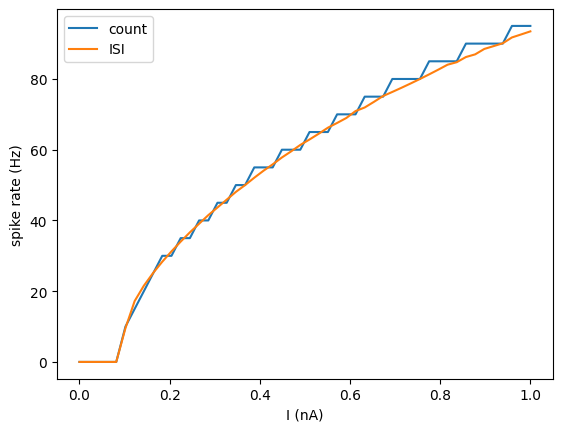

In [6]:
plt.plot(neuron.I_stim/nA, spike_mon.count/(200*ms), label="count")
spike_trains = spike_mon.spike_trains()
rates_based_on_ISI = []
for neuron_idx in range(len(neuron)):
    if spike_mon.count[neuron_idx] <= 1:
        rates_based_on_ISI.append(0)
    else:
        rates_based_on_ISI.append(1/np.mean(np.diff(spike_trains[neuron_idx])))
plt.plot(neuron.I_stim/nA, rates_based_on_ISI, label="ISI")
plt.legend(); plt.xlabel("I (nA)"); plt.ylabel("spike rate (Hz)");

Answer: the spike rate based on the ISI is smooth, since it does not show the discretization artifact: there are only entire numbers of spikes during the simulation, so the rate can only be entire multiples of 5Hz (for a simulation time of 200ms).

4. How does the f/I curve of a neuron change with changes in $E_L$ ? How does it change with changes in $g_L$ ? Do simulations where you change either $E_L$ or $g_L$, and plot their f/I curves into the same plot to compare them.

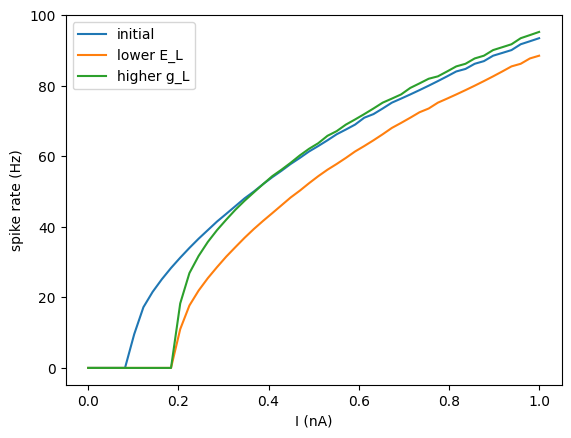

In [7]:
def plot_fI(spike_mon, label, n_neurons=50):
    spike_trains = spike_mon.spike_trains()
    rates_based_on_ISI = []
    for neuron_idx in range(n_neurons):
        if spike_mon.count[neuron_idx] <= 1:
            rates_based_on_ISI.append(0)
        else:
            rates_based_on_ISI.append(1/np.mean(np.diff(spike_trains[neuron_idx])))
    plt.plot(neuron.I_stim/nA, rates_based_on_ISI, label=label)

def simulate(E_L, g_L):
    start_scope()

    neuron = NeuronGroup(50, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
    neuron.V = E_L
    neuron.I_stim = np.linspace(0, 1, len(neuron))*nA

    spike_mon = SpikeMonitor(neuron)
    run(500*ms)
    return spike_mon

spikes = simulate(E_L = -60*mV, g_L = (50*usiemens*cm**-2) * area)
plot_fI(spikes, "initial")
spikes = simulate(E_L = -70*mV, g_L = (50*usiemens*cm**-2) * area)
plot_fI(spikes, "lower E_L")
spikes = simulate(E_L = -60*mV, g_L = (100*usiemens*cm**-2) * area)
plot_fI(spikes, "higher g_L")
plt.legend(); plt.xlabel("I (nA)"); plt.ylabel("spike rate (Hz)");

*Answer*: Changes in $E_L$ means shifting the f/I curve left (higher values of $E_L$) or right (lower values of $E_L$). Changes in $g_L$ also shift the threshold of the f/I curve left or right (but in the opposite way, i.e. higher $g_L$ means higher threshold), but does not affect the firing rate for high currents. 